In [1]:
import os

SUBJECTS_N = 24

recording_names_path        = "baseline/etc/indexes/index_all.txt"  
recording_sumaries_path     = "baseline/etc/summaries/"
recording_sumaries_prologue = "chb"
recording_sumaries_epilogue = "-summary.txt"
selected_indexes_path       = "baseline/indexes_detection/new/"
selected_indexes_path_orig  = "baseline/indexes_detection/"
selected_indexes_prologue   = "../clean_signals/chb"
selected_indexes_name_train = "train.txt"
selected_indexes_name_test  = "test.txt"
selected_indexes_name_valid = "validation.txt"

line_recording_name_start   = "File Name: chb"
line_recording_name_end     = ".edf\n"
line_seizures_start         = "Number of Seizures in File: "

with open(recording_names_path) as n: 
    names = n.readlines()
filename_recordings = [n.strip() for n in names]


subjects = {}

for subject_idx in range(1, SUBJECTS_N + 1 ):
    subject_name = f"{subject_idx:02d}"
    subjects[subject_name] = {}
    filename = recording_sumaries_path \
                + recording_sumaries_prologue \
                + subject_name \
                + recording_sumaries_epilogue
    if not os.path.isfile(filename):
        print(f"(!) No summary file for subject {subject_idx:02d}")
    else:
        with open(filename) as f:
            data = f.readlines()
        
        subjects[subject_name]['sz@rec'] = {}
        for l in data:
            if l.startswith(line_recording_name_start):
                record_name     = l[len(line_recording_name_start)+3:-len(line_recording_name_end)]
            if l.startswith(line_seizures_start):
                seizures = int(l[len(line_seizures_start):].strip())
                subjects[subject_name]['sz@rec'][record_name] = seizures

if 0:
    import pprint
    pprint.pprint(subjects)



(!) No summary file for subject 17


Make an array with only the amount of seizures detected in each recording

In [2]:
for s, s_i in zip(subjects, range(SUBJECTS_N)):
    seizures_l = []
    try:
        seizures = subjects[s]["sz@rec"]
        for r in seizures:
            seizures_l.append(seizures[r])
    except KeyError:
        pass
    subjects[s]['seizures'] = seizures_l


In [3]:
import os

# Path to the main directory
main_directory = selected_indexes_path_orig

# Function to read labels from a file
def read_labels(file_path, label):
    recordings = []
    with open(file_path, "r") as file:
        for line in file:
            # Assuming each line contains the relative path
            recordings.append((line.strip(), label))
    return recordings

# Initialize a list to store labels for each subject
all_subject_labels = []

# Loop through subjects from chb01 to chb24
for subject_num in range(1, SUBJECTS_N+1):
    subject_folder = f"chb{subject_num:02d}/"
    subject_path = main_directory + subject_folder

    # Read labels for train, test, and validation
    train_labels = read_labels(subject_path + selected_indexes_name_train, 0)
    test_labels = read_labels(subject_path + selected_indexes_name_test, 1)
    validation_labels = read_labels(subject_path + selected_indexes_name_valid, 2)

    # Merge labels into a single list while maintaining order
    all_labels = train_labels + validation_labels + test_labels

    # Sort labels by the recording IDs
    sorted_labels = sorted(all_labels, key=lambda x: int(x[0].split("/")[-1].split("_")[-1].rstrip('+')))

    # Extract labels for the subject
    subject_labels = [label for recording, label in sorted_labels]

    # Append labels for the subject to the list
    all_subject_labels.append(subject_labels)


Add to the subjects dictionary the index of the first training recording

In [4]:
for subject, sub_i in zip(subjects, range(1,SUBJECTS_N+1)):
    N = len(subjects[subject]['seizures'])
    # At least 5 recordings will be used for testing
    # A maximum of half the recordings will be used for test
    K = -1
    for i in range( 5, int(N/2) ):
        k = N -i
        train_range = subjects[subject]['seizures'][:k]
        test_range  = subjects[subject]['seizures'][k:]
        # All train ranges should have at least one seizure recording
        # All test ranges should have at least one seizure recording
        if any(element != 0 for element in train_range) and any(element != 0 for element in test_range): 
            K = k
            break
    subjects[f"{sub_i:02d}"]["test"] = K

Plot which records have seizures and which will be used for testing 

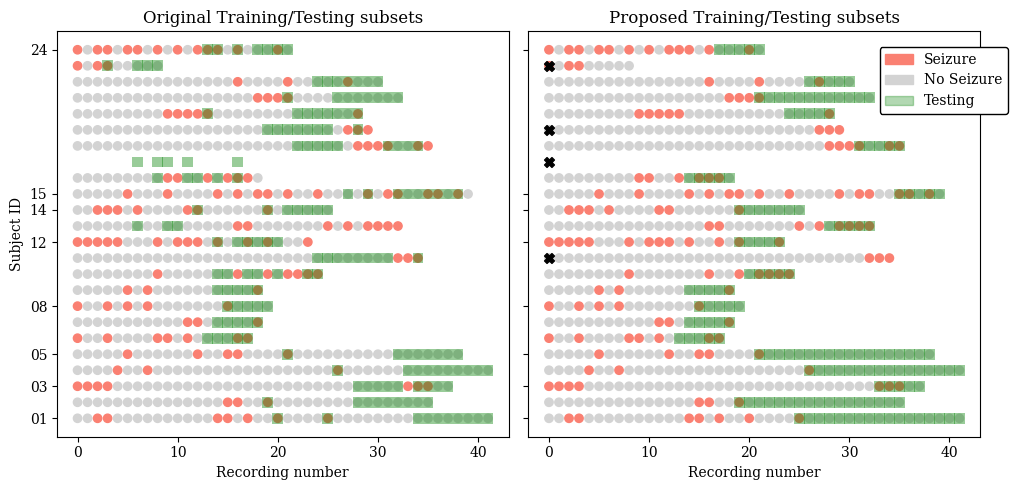

In [5]:
import matplotlib.pyplot as plt
import numpy as np


squaresize = 60
squarealpha = 0.4
seizure_color = 'salmon'
nonseizure_color = 'lightgray'
testing_color = 'green'

plt.rcParams["font.family"] = "serif"
fig, axs = plt.subplots(1,2, figsize=(10,5), sharey=True)

for subject in subjects:
# for seiz, offset in zip(seizs, offsets):
    offset = int(subject)
    seiz = np.asarray(subjects[subject]['seizures'])
    x = range(len(seiz))
    points = [offset for _ in seiz]
    color =     [ seizure_color if s > 0 else nonseizure_color for s in seiz ]

    axs[0].scatter(x, points, color=color)

    subject_idx = int(subject)
    test_x = []
    test_y = []
    for i in range(len(all_subject_labels[subject_idx-1])):
        if all_subject_labels[subject_idx-1][i] == 1:
            test_x.append(i)
            test_y.append(subject_idx)
    axs[0].scatter(test_x, test_y, color=testing_color, marker="s", s=squaresize, alpha=squarealpha, edgecolors='none')

    # else:
    #     plt.scatter([0],[offset], color='k', marker='X')

axs[0].set_xlabel("Recording number")
axs[0].set_ylabel("Subject ID")
axs[0].set_title("Original Training/Testing subsets");





for subject in subjects:
# for seiz, offset in zip(seizs, offsets):
    offset = int(subject)
    seiz = np.asarray(subjects[subject]['seizures'])
    x = range(len(seiz))
    points = [offset for _ in seiz]
    color =     [ seizure_color if s > 0 else nonseizure_color for s in seiz ]
    axs[1].scatter(x, points, color=color)

    if subjects[subject]["test"] != -1:
        test_x = range(subjects[subject]["test"],len(seiz))
        test_y = [ offset for _ in test_x ]
        axs[1].scatter(test_x, test_y, color=testing_color, marker="s", s=squaresize, alpha=squarealpha, edgecolors='none')
    else:
        axs[1].scatter([0],[offset], color='k', marker='X', s=50)

axs[1].set_xlabel("Recording number")
# axs[1].set_ylabel("Subject ID")
axs[1].set_title("Proposed Training/Testing subsets")

axs[0].set_yticks([1, 3, 5, 8, 12, 14, 15, 24])
axs[0].set_yticklabels(["01", "03", "05", "08", "12", "14", "15", "24"])


import matplotlib.patches as mpatches
# Create custom legend handles and labels
legend_handles = [mpatches.Circle((0, 0), 1, color=seizure_color, label='Seizure'),
                  mpatches.Circle((0, 0), 1, color=nonseizure_color, label='No Seizure'),
                  mpatches.Circle((0, 0), 1, color=testing_color, alpha = 0.3, label='Testing')]
# Add legend with custom handles and labels
fig.legend(handles=legend_handles, bbox_to_anchor=(1.02, 0.91), fancybox=True, framealpha=1, edgecolor='black');


plt.tight_layout()

Generate the new indexes for training and testing

In [6]:
if 1:
    for subject in subjects:
        test_start = subjects[subject]["test"]
        if test_start != -1:
            recs_to_train = list(subjects[subject]['sz@rec'].keys())[:test_start]
            recs_to_test = list(subjects[subject]['sz@rec'].keys())[test_start:]
            
            
            filename = selected_indexes_path \
                        + recording_sumaries_prologue \
                        + subject +"/"\
                        + selected_indexes_name_train
            
            os.makedirs(os.path.dirname(filename), exist_ok=True)

            with open(filename, 'w+') as f:
                for r in recs_to_train:
                    line = selected_indexes_prologue +subject+"/chb"+ subject + "_" + r + "\n"
                    f.write(line)
            
            filename = selected_indexes_path \
                        + recording_sumaries_prologue \
                        + subject +"/"\
                        + selected_indexes_name_test

            with open(filename, 'w+') as f:
                for r in recs_to_test:
                    line = selected_indexes_prologue +subject+"/chb"+ subject + "_" + r + "\n"
                    f.write(line)


In [15]:
import pickle
with open("/home/juan/Desktop/ML/project2/baseline/keras_pipeline/python/dg.pkl", 'rb') as p:
    dg = pickle.load(p)

print(len(dg))

2343


Record 6: 417-532
Record 13: 1086-1196
Record 16: 2317-2413
Record 17: 2451-2571
Record 22: 2348-2465
Total recordings on training: 20 = 72000 seconds
[[6, 417, 532], [13, 1086, 1196], [16, 2317, 2413], [17, 2451, 2571], [22, 2348, 2465]]
[[6, 18417, 18532], [13, 44286, 44396], [16, 56317, 56413], [17, 60051, 60171], [22, 77948, 78065]]
[0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1]


Text(0, 0.5, 'Accuracy')

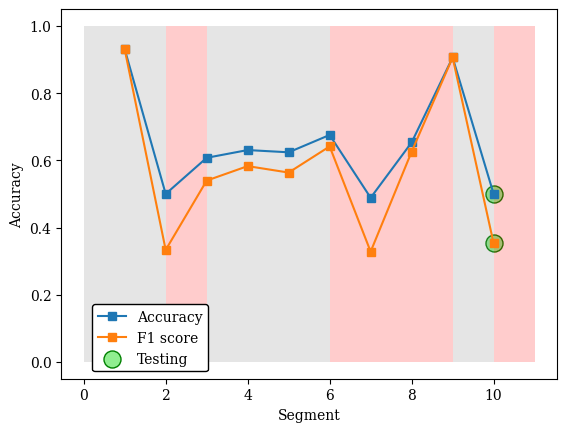

In [89]:

subject_name = '05'
filename = recording_sumaries_path \
            + recording_sumaries_prologue \
            + subject_name \
            + recording_sumaries_epilogue

with open(filename) as f:
    data = f.readlines()


line_seizures_time_start    = 'Seizure Start Time: '
line_seizures_time_end      = 'Seizure End Time: '
line_seizures_seconds       = ' seconds\n'

rec = 0
szs = []
for l in data:
    if l.startswith(line_recording_name_start):
        rec += 1
    if l.startswith(line_seizures_time_start):
        s = int(l[len(line_seizures_time_start):-len(line_seizures_seconds)].strip())
    if l.startswith(line_seizures_time_end):
        e = int(l[len(line_seizures_time_end):-len(line_seizures_seconds)].strip())
        print(f"Record {rec}: {s}-{e}")
        szs.append( [rec, s, e ] )  

train_recs = subjects[subject_name]['test']-1
total_seconds = train_recs*3600
print(f"Total recordings on training: {train_recs} = {total_seconds} seconds")

segments = len(dg)
blocks = 10
seconds_per_block = total_seconds/blocks
seg_per_block = int(segments/blocks)

print(szs)
for r in szs:
    r[1] += (r[0]-1)*3600
    r[2] += (r[0]-1)*3600
print(szs)

bls = [0]*blocks
for b in range(blocks):
    block_start = b*seconds_per_block
    block_end = (b+1)*seconds_per_block
    bls[b] = 0
    for r in szs:
        if (block_start <= r[1] and block_end >= r[2] )\
            or (block_start >= r[1] and block_start <= r[2] )\
            or (block_end >= r[1] and block_end <= r[2] ):
            bls[b] = 1

# Add the testing block
bls.append(1)

print(bls)



#######################################


with open("/home/juan/Desktop/ML/project2/baseline/keras_pipeline/scripts/keras_experiments/detection_recurrent_chb05_test/training.log",'r') as f:
    data = f.readlines()

accs = []
f1s = []
for li in range(1,len(data)-1):
    l = data[li]
    pieces = l.split(',')
    accs.append(float(pieces[-2].strip()))
    f1s.append(float(pieces[-1].strip()))
    

# Add the testing results
test_acc = 0.5
test_f1 = 0.353
accs.append(test_acc)
f1s.append(test_f1)


import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
fig, ax = plt.subplots()

ax.plot(range(1,len(accs)+1), accs   ,marker='s')
ax.plot(range(1,len(accs)+1), f1s    ,marker='s')

# Add the test result
ax.scatter(len(accs), test_acc, marker='o', s=150, linewidth=1, edgecolors='green', color='lightgreen' )
ax.scatter(len(accs), test_f1,  marker='o', s=150, linewidth=1, edgecolors='green', color='lightgreen' )


ax.legend(['Accuracy','F1 score', 'Testing'],  bbox_to_anchor=(0.31, 0.22), fancybox=True, framealpha=1, edgecolor='black')

import matplotlib.patches as patches
for b in range(len(bls)): 
    color = "red" if bls[b] == 1 else "gray"
    rect = patches.Rectangle((b, 0), 1, 1, linewidth=0, facecolor=color, alpha=0.2)
    # Add the rectangle to the plot
    ax.add_patch(rect)

ax.set_xlabel("Segment")
ax.set_ylabel("Accuracy")